In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

np.random.sample(1337)

data_path = '/content/drive/MyDrive/SolarGen/'

## Baseline

In [11]:
df_train = pd.read_csv(data_path + './data/train/train.csv')
submission = pd.read_csv(data_path + './data/sample_submission.csv')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, 
    MaxAbsScaler, PowerTransformer
)

class ScalingFactor:
    def __init__(self, scaler, features):
        self.scaler = scaler
        self.features = features

def scaling(data, scaler, features, is_train=True):

    temp = data.copy()

    target_cols = features
    temp = temp[target_cols]
    if is_train: 
        scaler.fit(temp)
    scaled = scaler.transform(temp)

    data[target_cols] = scaled

    return data

def slicing_data(data, window_size):

    slices = []

    for i in range(len(data) - window_size):
        slices.append(np.array(data[i:i+window_size]))

    return np.array(slices)

def preprocess_data(data, scale_factors, window_size, is_train=True):
    
    temp = data.copy()

    for factor in scale_factors:
        temp = scaling(temp, factor.scaler, factor.features, is_train)

    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
    temp_np = temp.to_numpy()

    if is_train==True:          
    
        temp = slicing_data(temp_np, window_size)
        
        return temp[:-96]

    elif is_train==False:

        temp = slicing_data(temp_np, window_size)
                              
        return temp[-1]

scale_factors = []
scale_factors.append(ScalingFactor(PowerTransformer(), ['DHI', 'DNI']))
# scale_factors.append(ScalingFactor(QuantileTransformer(output_distribution='normal'), ['DNI']))
scale_factors.append(ScalingFactor(StandardScaler(), ['WS', 'RH', 'T']))
scale_factors.append(ScalingFactor(MinMaxScaler(), ['DHI', 'DNI', 'WS', 'RH', 'T']))

window_size = 48
train = preprocess_data(df_train, scale_factors, window_size)
train_label = slicing_data(df_train.iloc[window_size:]['TARGET'], 48)

# train[0].iloc[:, 1:].plot(subplots=True, layout=(1,6), figsize=(30,4))
# train[0].iloc[:, 1:].hist(bins = 100, layout=(1,6), figsize=(30,4))
train.shape, train_label.shape

((52416, 48, 7), (52416, 96))

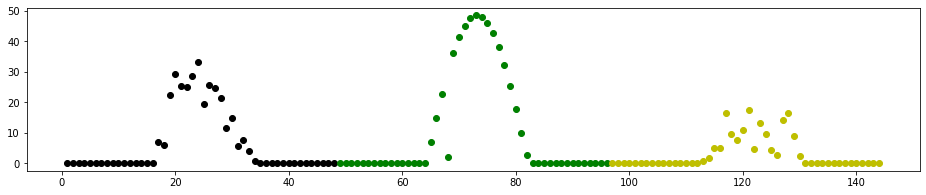

In [12]:
nth_data = 0
fig, ax = plt.subplots(figsize=(16,3))
ax.scatter([i+1 for i in range(48)], train[nth_data][:,1], color='k')
ax.scatter([i+49 for i in range(48)], train_label[nth_data], color='g')
ax.scatter([i+97 for i in range(48)], train_label[nth_data+48], color='y')

In [13]:
test = []

for i in range(81):
    file_path = data_path + './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, scale_factors, window_size, is_train=False)
    test.append(temp)

# X_test[0].iloc[:, 1:].plot(subplots=True, layout=(1,6), figsize=(30,4))
# X_test[0].iloc[:, 1:].hist(bins = 100, layout=(1,6), figsize=(30,4))

X_test = np.array(test)
X_test.shape

(81, 48, 7)

In [15]:
from sklearn.model_selection import train_test_split
X_train1, X_valid1, Y_train1, Y_valid1 = train_test_split(train, train_label[:-48], test_size=0.3, random_state=0, shuffle=False)
X_train2, X_valid2, Y_train2, Y_valid2 = train_test_split(train, train_label[48:], test_size=0.3, random_state=0, shuffle=False)

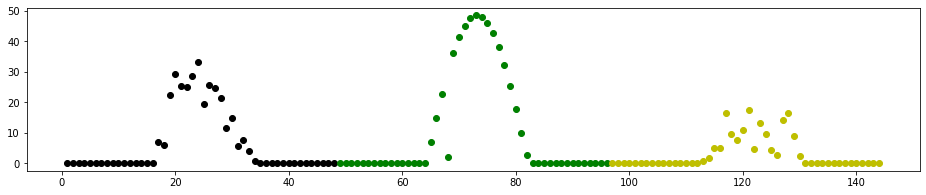

In [16]:
nth_data = 0
fig, ax = plt.subplots(figsize=(16,3))
ax.scatter([i+1 for i in range(48)], X_train1[nth_data][:,1], color='k')
ax.scatter([i+49 for i in range(48)], Y_train1[nth_data], color='g')
ax.scatter([i+97 for i in range(48)], Y_train2[nth_data], color='y')

In [17]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [19]:
from tensorflow.keras.layers import LSTM, Dense

rnn_layer = 48
hidden_layer = 96

models1 = []
models2 = []

def ploss(q):

    def pinball_loss(y_true, y_pred):
        error = y_true - y_pred
        return K.mean(K.maximum(q*error, (q-1)*error), axis=-1)

    return pinball_loss

for q in quantiles:
    rnn = tf.keras.Sequential()
    rnn.add(LSTM(rnn_layer, input_shape=X_train1[0].shape))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(Y_train1[0].shape[0]))
    rnn.compile(loss=ploss(q=q), optimizer='adam')
    models1.append(rnn)

for q in quantiles:
    rnn = tf.keras.Sequential()
    rnn.add(LSTM(rnn_layer, input_shape=X_train2[0].shape))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(hidden_layer, activation='relu'))
    rnn.add(Dense(Y_train2[0].shape[0]))
    rnn.compile(loss=ploss(q=q), optimizer='adam')
    models2.append(rnn)

models1[0].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48)                10752     
_________________________________________________________________
dense (Dense)                (None, 96)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_5 (Dense)              (None, 48)               

In [20]:
batch_size = 128
epochs = 200

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

for index, model in enumerate(models1):
    print("[Q = %.1f]"%((index+1)*0.1))
    best_model = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SolarGen/model/m1_best_%d.h5'%((index+1)), 
                                                monitor='val_loss', verbose=1, save_best_only=True)
    model.fit(X_train1, Y_train1, validation_data=(X_valid1, Y_valid1), epochs=epochs, 
              batch_size=batch_size, callbacks=[early_stopping, best_model])

for index, model in enumerate(models2):
    print("[Q = %.1f]"%((index+1)*0.1))
    best_model = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SolarGen/model/m2_best_%d.h5'%((index+1)), 
                                                monitor='val_loss', verbose=1, save_best_only=True)
    model.fit(X_train2, Y_train2, validation_data=(X_valid2, Y_valid2), epochs=epochs, 
              batch_size=batch_size, callbacks=[early_stopping, best_model])

[Q = 0.1]
Epoch 1/200
287/287 [==============================] - 5s 7ms/step - loss: 1.7303 - val_loss: 1.5770

Epoch 00001: val_loss improved from inf to 1.57702, saving model to /content/drive/MyDrive/SolarGen/model/m1_best_1.h5
Epoch 2/200
287/287 [==============================] - 2s 6ms/step - loss: 1.4031 - val_loss: 1.4733

Epoch 00002: val_loss improved from 1.57702 to 1.47333, saving model to /content/drive/MyDrive/SolarGen/model/m1_best_1.h5
Epoch 3/200
287/287 [==============================] - 2s 6ms/step - loss: 1.3491 - val_loss: 1.4499

Epoch 00003: val_loss improved from 1.47333 to 1.44995, saving model to /content/drive/MyDrive/SolarGen/model/m1_best_1.h5
Epoch 4/200
287/287 [==============================] - 2s 6ms/step - loss: 1.3244 - val_loss: 1.4553

Epoch 00004: val_loss did not improve from 1.44995
Epoch 5/200
287/287 [==============================] - 2s 6ms/step - loss: 1.3158 - val_loss: 1.4504

Epoch 00005: val_loss did not improve from 1.44995
Epoch 6/200
2

In [22]:
losses = []

for index in range(9):
    print('[m1_best_%d.h5]'%((index+1)))
    model = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/m1_best_%d.h5'%((index+1)),
                                    custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    losses.append(model.evaluate(X_valid1, Y_valid1))

for index in range(9):
    print('[m2_best_%d.h5]'%((index+1)))
    model = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/m2_best_%d.h5'%((index+1)),
                                    custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    losses.append(model.evaluate(X_valid2, Y_valid2))

np.average(losses)

[m1_best_1.h5]
492/492 [==============================] - 2s 3ms/step - loss: 1.4320
[m1_best_2.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.3064
[m1_best_3.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.7335
[m1_best_4.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.9252
[m1_best_5.h5]
492/492 [==============================] - 2s 2ms/step - loss: 2.8446
[m1_best_6.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.5094
[m1_best_7.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.0406
[m1_best_8.h5]
492/492 [==============================] - 2s 3ms/step - loss: 1.4743
[m1_best_9.h5]
492/492 [==============================] - 2s 3ms/step - loss: 0.7739
[m2_best_1.h5]
492/492 [==============================] - 2s 2ms/step - loss: 1.5246
[m2_best_2.h5]
492/492 [==============================] - 2s 3ms/step - loss: 2.5308
[m2_best_3.h5]
492/492 [==============================] - 2s 2ms/

2.1894445750448437

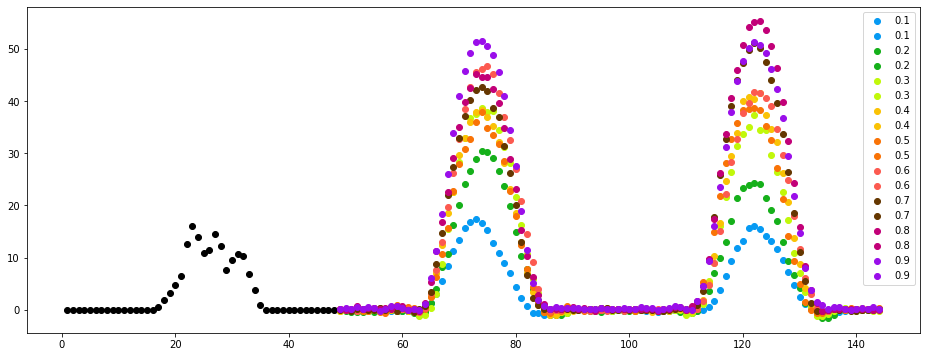

In [24]:
import matplotlib._color_data as mcd

nth_data = 0
fig, ax = plt.subplots(figsize=(16,6))
ax.scatter([i+1 for i in range(48)], X_test[nth_data][:,1], color='k')
colors = ["xkcd:azure", "xkcd:green", "xkcd:chartreuse", "xkcd:goldenrod",
          "xkcd:orange", "xkcd:coral", "xkcd:brown", "xkcd:magenta", "xkcd:violet"]
for index in range(9):
    model1 = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/m1_best_%d.h5'%((index+1)),
                                       custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    model2 = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/m2_best_%d.h5'%((index+1)),
                                       custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    color =  colors[index]
    ax.scatter([i+49 for i in range(48)], model1.predict(np.array([X_test[nth_data]])), color=color, label="%.1f"%((index+1)*0.1))
    ax.scatter([i+97 for i in range(48)], model2.predict(np.array([X_test[nth_data]])), color=color, label="%.1f"%((index+1)*0.1))
    ax.legend()

In [29]:
results1 = pd.DataFrame()
results2 = pd.DataFrame()

for index in range(9):
    model1 = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/m1_best_%d.h5'%((index+1)),
                                       custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    model2 = tf.keras.models.load_model('/content/drive/MyDrive/SolarGen/model/m2_best_%d.h5'%((index+1)),
                                       custom_objects={'pinball_loss': ploss((index+1)*0.1)})
    pred1 = pd.Series(np.reshape(model1.predict(X_test), -1))
    pred2 = pd.Series(np.reshape(model2.predict(X_test), -1))
    results1 = pd.concat([results1, pred1], axis=1)
    results2 = pd.concat([results2, pred2], axis=1)

results1.columns = quantiles
results2.columns = quantiles

In [31]:
results1 = results1.clip(0.0)
results2 = results2.clip(0.0)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.000000,0.000000,0.000000,0.000000,0.044610,0.000000,0.022958,0.050728,0.195014
1,0.000000,0.080216,0.000000,0.007522,0.047817,0.199698,0.000000,0.092913,0.169323
2,0.037687,0.000000,0.010742,0.097989,0.000000,0.000000,0.204658,0.179674,0.404393
3,0.000000,0.000000,0.043886,0.000000,0.000000,0.000000,0.000000,0.214750,0.121043
4,0.000000,0.000000,0.175784,0.000000,0.000000,0.102029,0.067316,0.150421,0.209586
...,...,...,...,...,...,...,...,...,...
3883,0.000000,0.346919,0.000000,0.253466,0.385180,0.530754,0.000000,0.354946,0.474194
3884,0.000000,0.000000,0.242750,0.218010,0.565817,0.043010,0.000000,0.384123,0.555972
3885,0.047018,0.085840,0.000000,0.155587,0.203169,0.000000,0.000000,0.523659,0.670158
3886,0.000000,0.074810,0.000000,0.000000,0.741735,0.312423,0.000000,0.051357,0.531209


In [33]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results1.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results2.values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.016506,0.00000,0.000000,0.183739,0.035805,0.000000,0.202587,0.036859
1,0.csv_Day7_0h30m,0.012137,0.000000,0.00000,0.000000,0.034262,0.000000,0.111068,0.000000,0.365058
2,0.csv_Day7_1h00m,0.000008,0.000000,0.00000,0.000000,0.183892,0.000000,0.000000,0.109436,0.143112
3,0.csv_Day7_1h30m,0.000000,0.000000,0.00000,0.000000,0.503183,0.000000,0.037122,0.618546,0.423160
4,0.csv_Day7_2h00m,0.000000,0.000000,0.00000,0.000000,0.000000,0.102827,0.159175,0.218788,0.123303
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.000000,0.346919,0.00000,0.253466,0.385180,0.530754,0.000000,0.354946,0.474194
7772,80.csv_Day8_22h00m,0.000000,0.000000,0.24275,0.218010,0.565817,0.043010,0.000000,0.384123,0.555972
7773,80.csv_Day8_22h30m,0.047018,0.085840,0.00000,0.155587,0.203169,0.000000,0.000000,0.523659,0.670158
7774,80.csv_Day8_23h00m,0.000000,0.074810,0.00000,0.000000,0.741735,0.312423,0.000000,0.051357,0.531209


In [34]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.016506,0.000000,0.000000,0.183739,0.035805,0.000000,0.202587,0.036859
1,0.csv_Day7_0h30m,0.012137,0.000000,0.000000,0.000000,0.034262,0.000000,0.111068,0.000000,0.365058
2,0.csv_Day7_1h00m,0.000008,0.000000,0.000000,0.000000,0.183892,0.000000,0.000000,0.109436,0.143112
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.503183,0.000000,0.037122,0.618546,0.423160
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.102827,0.159175,0.218788,0.123303
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.183860,0.000000,0.056921,0.018384,0.396164,0.434031
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.048070,0.205618,0.231483,0.031364,0.364749,0.301555
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.146269,0.000000,0.226502,0.303554,0.086726,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.114246,0.000000,0.272941,0.215401
9,0.csv_Day7_4h30m,0.000000,0.000000,0.119566,0.000000,0.053836,0.405510,0.541446,0.094515,0.662514


In [ ]:
# submission.to_csv(data_path + './data/submission.csv', index=False)